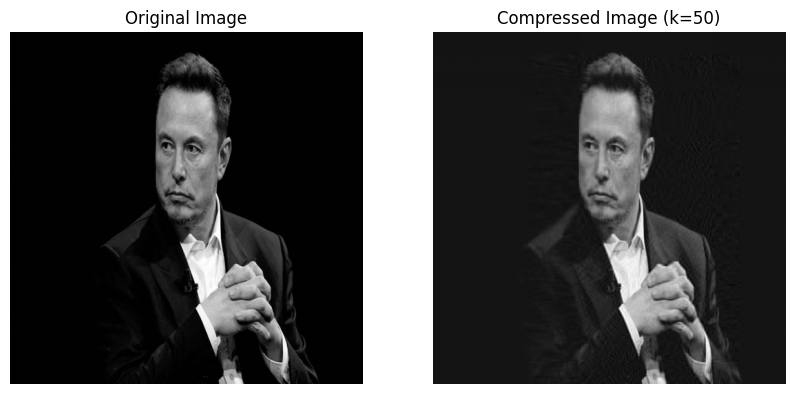

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 샘플 이미지 생성 (사용자가 이미지를 업로드하면 그 이미지로 변경 가능)
image_size = 512  # 128x128 크기의 랜덤 이미지 생성
image_matrix = Image.open("test.jpg").convert("L").resize((image_size, image_size))
image_matrix = np.array(image_matrix)

# SVD 수행
U, Sigma, Vt = np.linalg.svd(image_matrix, full_matrices=False)

# 압축할 특이값 개수 선택 (예: 20개만 유지)
k = 50
compressed_image = np.dot(U[:, :k], np.dot(np.diag(Sigma[:k]), Vt[:k, :]))

# 원본 및 압축된 이미지 출력
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_matrix, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(compressed_image, cmap="gray")
axes[1].set_title(f"Compressed Image (k={k})")
axes[1].axis("off")

plt.show()

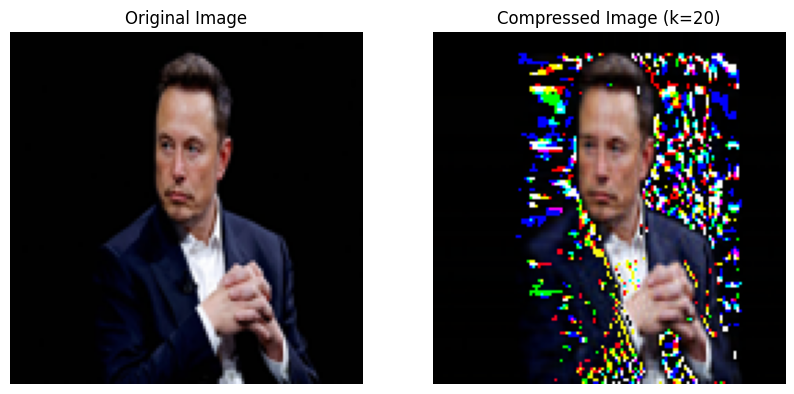

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 이미지 로드 및 변환
image_size = 128
image = Image.open("test.jpg").resize((image_size, image_size))
image_matrix = np.array(image)

# RGB 3채널에 대해 개별적으로 SVD 적용
compressed_channels = []
k = 20  # 압축할 특이값 개수

for i in range(3):  # R, G, B 채널에 대해 반복
    U, Sigma, Vt = np.linalg.svd(image_matrix[:, :, i], full_matrices=False)
    compressed = np.dot(U[:, :k], np.dot(np.diag(Sigma[:k]), Vt[:k, :]))
    compressed_channels.append(compressed)

# 3채널 합치기
compressed_image = np.stack(compressed_channels, axis=2).astype(np.uint8)

# 원본 및 압축된 이미지 출력
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_matrix)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(compressed_image)
axes[1].set_title(f"Compressed Image (k={k})")
axes[1].axis("off")

plt.show()

### Power iteration

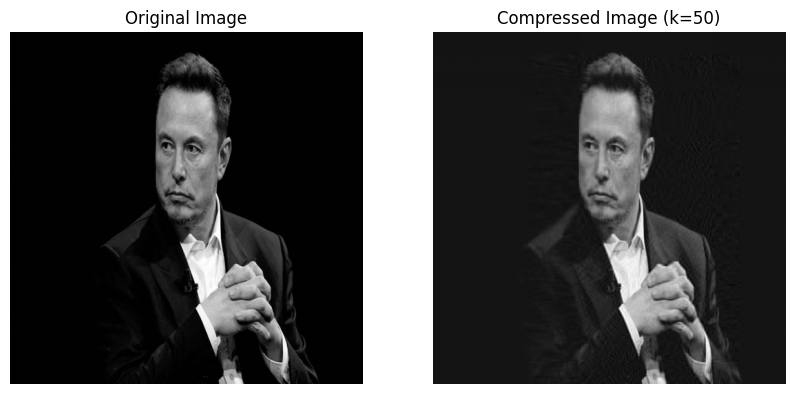

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def power_iteration(A, num_iter=1000, tol=1e-10):
    """Power Iteration을 이용하여 가장 큰 고유값과 특이벡터를 구하는 함수"""
    n, m = A.shape
    v = np.random.rand(m)
    v /= np.linalg.norm(v)  # 정규화

    for _ in range(num_iter):
        v_new = A.T @ (A @ v)  # A^T A v
        v_new /= np.linalg.norm(v_new)  # 정규화

        if np.linalg.norm(v - v_new) < tol:
            break
        v = v_new

    eigenvalue = v.T @ A.T @ A @ v
    return np.sqrt(eigenvalue), v  # 특이값과 대응하는 특이벡터 반환

def compute_svd(A, k=None):
    """NumPy 없이 직접 SVD 계산 (Power Iteration + QR 알고리즘 기반)"""
    A = A.astype(float)  # 정수형 행렬을 float으로 변환하여 계산 오류 방지
    m, n = A.shape
    if k is None:
        k = min(m, n)  # 특이값 개수 (전체)

    U = np.zeros((m, k))
    Sigma = np.zeros((k, k))
    V = np.zeros((n, k))

    A_copy = np.copy(A)

    for i in range(k):
        sigma, v = power_iteration(A_copy)  # 가장 큰 특이값과 특이벡터 찾기
        u = A @ v / sigma  # 좌측 특이벡터 u 계산

        U[:, i] = u  # U 행렬에 저장
        Sigma[i, i] = sigma  # Sigma 대각 행렬 저장
        V[:, i] = v  # V 행렬에 저장

        # Rank-1 근사 제거 (SVD 업데이트)
        A_copy -= sigma * np.outer(u, v)

    return U, Sigma, V.T

# 이미지 로드 및 전처리
image_size = 512  # Resize to 512x512 pixels
image = Image.open("test.jpg").convert("L").resize((image_size, image_size))
image_matrix = np.array(image, dtype=np.float64)  # Convert to float64

# 직접 구현한 SVD 수행
U, Sigma, Vt = compute_svd(image_matrix)

# 압축할 특이값 개수 선택 (예: 5개만 유지)
k = 50
compressed_image = np.dot(U[:, :k], np.dot(Sigma[:k, :k], Vt[:k, :])).real  # Convert complex to real

# 원본 및 압축된 이미지 출력
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_matrix, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(compressed_image, cmap="gray")
axes[1].set_title(f"Compressed Image (k={k})")
axes[1].axis("off")

plt.show()

### QR Decomposition

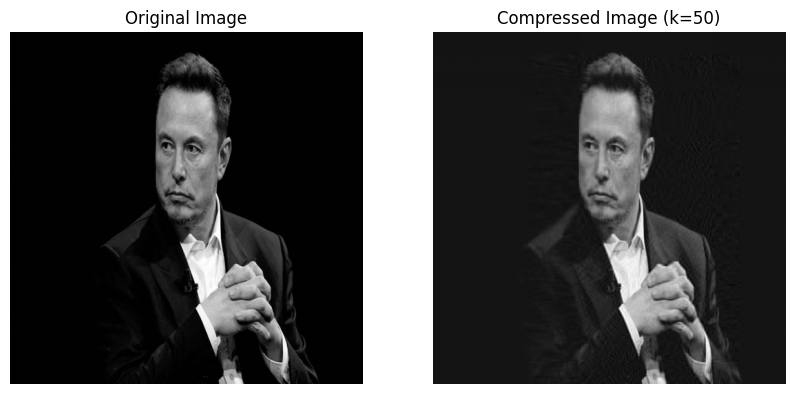

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def qr_algorithm(A, num_iter=1000, tol=1e-10):
    """QR 알고리즘을 이용하여 행렬의 고유값과 고유벡터를 계산"""
    m, n = A.shape
    V = np.eye(n)
    
    A_k = A.T @ A  # A^T A를 계산하여 V를 구할 준비

    for _ in range(num_iter):
        Q, R = np.linalg.qr(A_k)  # QR 분해 수행
        A_k = R @ Q  # 행렬 갱신
        V = V @ Q  # V 갱신

        if np.allclose(A_k - np.diag(np.diag(A_k)), 0, atol=tol):
            break

    eigenvalues = np.diag(A_k)  # 대각 원소가 고유값
    return np.sqrt(np.abs(eigenvalues)), V  # 특이값과 우측 특이벡터 반환

def compute_svd_qr(A):
    """QR 알고리즘을 이용한 SVD 직접 구현"""
    m, n = A.shape
    if m >= n:
        Sigma, V = qr_algorithm(A)
        U = A @ V / Sigma  # 좌측 특이벡터 계산
    else:
        Sigma, U = qr_algorithm(A.T)
        V = A.T @ U / Sigma  # 우측 특이벡터 계산

    return U, np.diag(Sigma), V.T

# 이미지 로드 및 전처리
image_size = 512
image = Image.open("test.jpg").convert("L").resize((image_size, image_size))
image_matrix = np.array(image, dtype=np.float64)

# QR 알고리즘을 이용한 SVD 수행
U, Sigma, Vt = compute_svd_qr(image_matrix)

# 압축할 특이값 개수 선택
k = 50
compressed_image = np.dot(U[:, :k], np.dot(Sigma[:k, :k], Vt[:k, :])).real  # 복소수 방지

# 원본 및 압축된 이미지 출력
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_matrix, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(compressed_image, cmap="gray")
axes[1].set_title(f"Compressed Image (k={k})")
axes[1].axis("off")

plt.show()

### Householder QR Decomposition

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
def householder_qr(A):
    """Householder 변환을 이용한 QR 분해"""
    m, n = A.shape
    Q = np.eye(m)
    R = A.copy()

    for i in range(n):
        x = R[i:, i]
        e1 = np.zeros_like(x)
        e1[0] = np.linalg.norm(x)
        v = x + np.sign(x[0]) * e1
        v /= np.linalg.norm(v)

        H = np.eye(m)
        H[i:, i:] -= 2.0 * np.outer(v, v)

        R = H @ R
        Q = Q @ H.T

    return Q, R


def householder_svd(A, num_iter=1000, tol=1e-10):
    """Householder 변환을 이용한 SVD 직접 구현"""
    m, n = A.shape
    A_TA = A.T @ A  # A^T A 계산하여 특이값 찾기
    
    # QR 알고리즘을 이용하여 V 계산
    V, R = householder_qr(A_TA)
    
    # 특이값 계산 (고유값의 제곱근)
    singular_values = np.sqrt(np.abs(np.diag(R)))
    
    # U 행렬 계산
    U = A @ V / singular_values
    
    return U, np.diag(singular_values), V.T

# 이미지 로드 및 전처리
image_size = 512
image = Image.open("test.jpg").convert("L").resize((image_size, image_size))
image_matrix = np.array(image, dtype=np.float64)

# Householder 변환을 이용한 SVD 수행
U, Sigma, Vt = householder_svd(image_matrix)

# 압축할 특이값 개수 선택
k = 50
compressed_image = np.dot(U[:, :k], np.dot(Sigma[:k, :k], Vt[:k, :])).real  # 복소수 방지

# 원본 및 압축된 이미지 출력
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_matrix, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(compressed_image, cmap="gray")
axes[1].set_title(f"Compressed Image (k={k})")
axes[1].axis("off")

plt.show()
